In [42]:
import numpy as np
import matplotlib.pyplot as plt


In [45]:
# 2 Variant
f_0 = 10 * 10**6 # МГц -> Гц
T = 5 * 10**(-6) # мкс -> c
q = 4
A = 1

N = 50
SNRdBMAX = 12
Nerrmax = 20

dt = 1 / (f_0 * N)
t = np.arange(0, T, dt)

SNR = 1.2589254117941673
Nerr = 20
Ntest = 47

SNR = 1.5848931924611136
Nerr = 20
Ntest = 51

SNR = 1.9952623149688795
Nerr = 20
Ntest = 63

SNR = 2.51188643150958
Nerr = 20
Ntest = 90

SNR = 3.1622776601683795
Nerr = 20
Ntest = 69

SNR = 3.9810717055349722
Nerr = 20
Ntest = 175

SNR = 5.011872336272722
Nerr = 20
Ntest = 201

SNR = 6.309573444801933
Nerr = 20
Ntest = 476

SNR = 7.943282347242816
Nerr = 20
Ntest = 1300

SNR = 10.0
Nerr = 20
Ntest = 1916

SNR = 12.589254117941675
Nerr = 20
Ntest = 4774



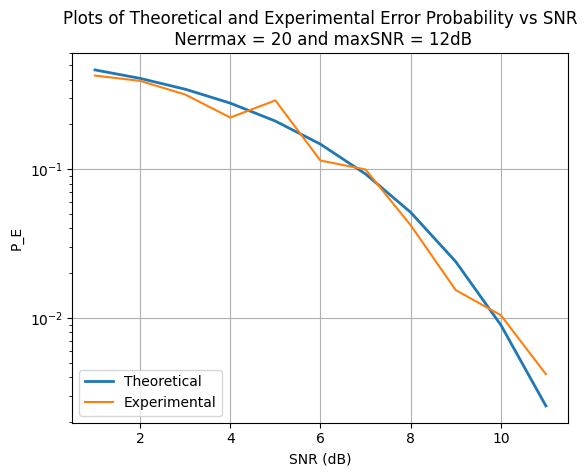

In [46]:
def Cnk(n, k):  # формула для С
    if k == 0 or k == n:
        return 1
    else:
        return Cnk(n - 1, k - 1) * n / k


s = np.zeros((q, len(t)))
phi_i_sin = np.zeros((q, len(t)))
phi_i_cos = np.zeros((q, len(t)))
s_i_sin = np.zeros((q, len(t)))
s_i_cos = np.zeros((q, len(t)))

f_i = f_0

for i in range(q):
    f_i = f_0 + (i - 1) / T
    arg = 2 * np.pi * f_i * t
    s[i, :] = A * np.cos(arg)
    phi_i_sin[i] = np.sqrt(2/T) * np.sin(arg)
    phi_i_cos[i] = np.sqrt(2/T) * np.cos(arg)
    s_i_sin[i, :] = A * np.sin(arg)
    s_i_cos[i, :] = A * np.cos(arg)


SNRdB = np.arange(1, SNRdBMAX, 1)  # Отношение сигнал/шум
Pe = np.zeros(len(SNRdB))  # Вероятность ошибки практическая
Pe_teor = np.zeros(len(SNRdB))  # Вероятность ошибки теоретическая

E = np.sum(np.square(s), axis=0) / q


for n in range(len(SNRdB)):
    SNR = 10**(SNRdB[n] / 10)  # Отношение сигнал/шум
    sigma = np.sqrt(np.sum(E / (2 * SNR)))  # Значение дисперсии отсчёта шума
    Nerr = 0  # Счётчик числа ошибок
    Ntest = 0  # Счётчик числа испытаний
    Pe_t = 0

    for l in range(1, q):
        Pe_t += Cnk(q - 1, l) * (-1)**(l + 1) * 1 / (1 + l) * np.exp(-l / (l + 1) * SNR)  # вероятность ошибки по точному значению

    # Моделирование передатчика и канала
    while Nerr < Nerrmax:
        i = np.random.randint(0, q)  # Случайный выбор сигнала
        theta = 2 * np.pi * np.random.rand()  # Случайная фаза
        
        r = np.cos(theta) * s_i_cos[i, :] + np.sin(theta) * s_i_sin[i, :] + sigma * np.random.randn(1, s[i, :].size)  # Сигнал на выходе канала
        r_ci = np.zeros((q, Nerrmax))
        r_si = np.zeros((q, Nerrmax))

        # Считаем значения для каждого сигнала
        for j in range(q):
            r_ci[j, :] = np.trapz(r * phi_i_cos[j, :], t)
            r_si[j, :] = np.trapz(r * phi_i_sin[j, :], t)  # Значение r_si
            
        # Формирование ^i по правилу
        i_hat = np.argmax((np.power(r_ci, 2) + np.power(r_si, 2)))

        # print(f'i_hat = {i_hat}, i = {i}')
        # Фиксация результата
        if (i_hat // Nerrmax) != i:
            Nerr += 1  # Увеличение счётчика числа ошибок

        Ntest += 1  # Увеличение числа испытаний

    Pe[n] = Nerr / Ntest  # Экспериментальная оценка вероятности ошибки
    SNR = 10**((n+1) / 10)  # Вычисление следующего значения SNR
    N0 = E / SNR

    Pe_teor[n] = Pe_t  # Теоретическая оценка вероятности ошибки
    print(f'SNR = {SNR}')
    print(f'Nerr = {Nerr}')
    print(f'Ntest = {Ntest}')
    print()


plt.figure()
plt.semilogy(SNRdB, Pe_teor, linewidth=2)
plt.semilogy(SNRdB, Pe)
plt.legend(['Theoretical', 'Experimental'], loc='lower left')
plt.title(f'Plots of Theoretical and Experimental Error Probability vs SNR\n Nerrmax = {Nerrmax} and maxSNR = {SNRdBMAX}dB')
plt.xlabel('SNR (dB)')
plt.ylabel('P_E')
plt.grid(True)
plt.show()